In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

In [85]:
br = yf.download(tickers='BRLUSD=X', period='1y', interval='1h')
eur = yf.download(tickers='EURUSD=X', period='1y', interval='1h')
xrp = yf.download(tickers='XRP-USD', period='1y', interval='1h')
xlm = yf.download(tickers='XLM-USD', period='1y', interval='1h')
solana = yf.download(tickers='SOL-USD', period='1y', interval='1h')
btc = yf.download(tickers='BTC-USD', period='1y', interval='1h')
silver = yf.download(tickers='SI=F', period='1y', interval='1h')
gold = yf.download(tickers='GC=F', period='1y', interval='1h')
libra = yf.download(tickers='GBPUSD=X', period='1y', interval='1h')
eth = yf.download(tickers='ETH-USD', period='1y', interval='1h')
oil = yf.download(tickers='CL=F', period='1y', interval='1h')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [86]:
master = pd.concat([br['Close'], eur['Close'], xrp['Close'], xlm['Close'], solana['Close'], btc['Close'], silver['Close'], gold['Close'], libra['Close'], eth['Close'], oil['Close']], axis=1)
master.columns = ['br', 'eur', 'xrp', 'xlm', 'solana', 'btc', 'silver', 'gold', 'libra', 'eth', 'oil']

In [87]:
# Conversion to 4hrs
data = master
data_4h = data[(data.index.astype('str').str.slice(11,13).astype('int') == 1) | (data.index.astype('str').str.slice(11,13).astype('int') == 5)
    | (data.index.astype('str').str.slice(11,13).astype('int') == 9) | (data.index.astype('str').str.slice(11,13).astype('int') == 13) |
    (data.index.astype('str').str.slice(11,13).astype('int') == 17) | (data.index.astype('str').str.slice(11,13).astype('int') == 21)]

<AxesSubplot: ylabel='Datetime'>

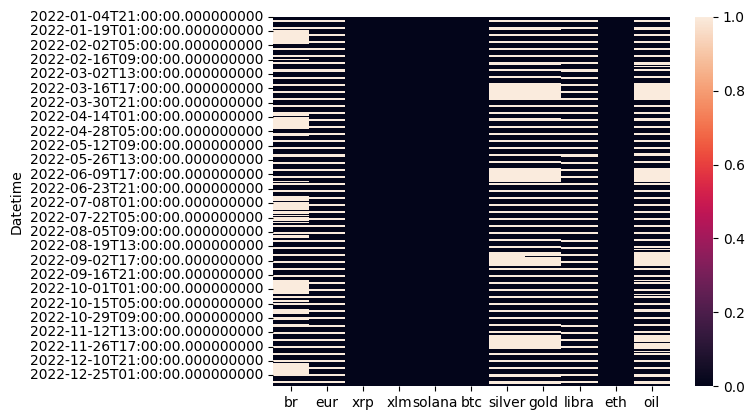

In [88]:
sns.heatmap(data_4h.isna())

In [89]:
#Dataset split to maximize information in predictions

#For stocks with full information, use just stocks with full information
features_full = data_4h.drop(['br', 'eur', 'silver', 'gold', 'libra', 'oil'], axis=1)
features_full

,xrp,xlm,solana,btc,eth
Datetime,,,,,
2022-01-04 21:00:00,NaN,NaN,NaN,NaN,NaN
2022-01-05 01:00:00,0.827424,0.280902,167.519363,46186.363281,3799.589844
2022-01-05 05:00:00,0.831047,0.284021,169.004868,46332.199219,3807.191162
2022-01-05 09:00:00,0.832944,0.293623,170.755295,46792.843750,3832.759277
2022-01-05 13:00:00,0.827381,0.291561,168.503998,46400.050781,3809.403809
...,...,...,...,...,...
2023-01-04 05:00:00,0.349278,0.074336,13.642331,16855.123047,1248.129761
2023-01-04 09:00:00,0.350023,0.074107,13.767684,16847.531250,1249.411621
2023-01-04 13:00:00,0.348956,0.074154,13.493308,16833.626953,1252.796021


In [90]:
#stationary = data_4h.pct_change(1)
stationary = features_full
series_names = stationary.columns

lag_1 = stationary.shift(1)
lag_2 = stationary.shift(2)
lag_3 = stationary.shift(3)
lag_4 = stationary.shift(4)
lag_5 = stationary.shift(5)
lag_6 = stationary.shift(6)

for i in range(1,7):
    exec(f"lag_{i}.columns = series_names + '_lag{i}'")
    
final_full = pd.concat([stationary, lag_1, lag_2, lag_3, lag_4, lag_5, lag_6], axis=1)
final_full.dropna(axis=0, inplace=True)

In [91]:
y = final_full["xrp"] #
x = final_full.iloc[:,5:] #past data

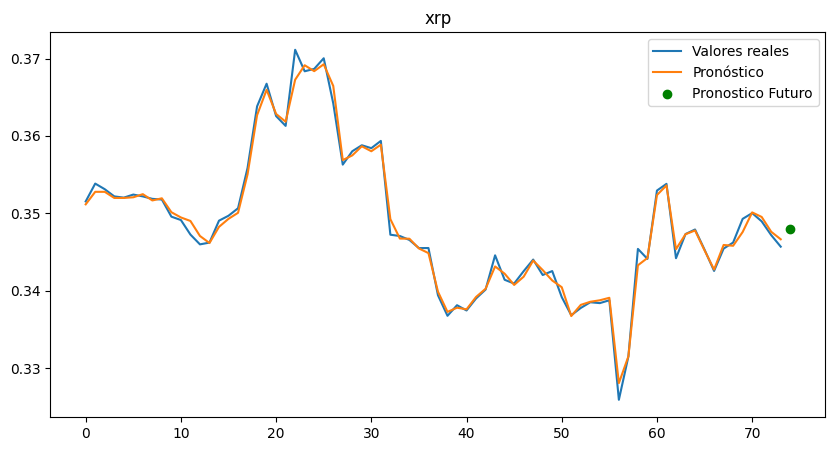

In [92]:
import xgboost as xgb
model = xgb.XGBRegressor(n_jobs=1, tree_method='hist', random_state=0, max_bin=500)
model.fit(x,y)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(y.values[-74:], label='Valores reales')
plt.plot(model.predict(x)[-74:], label='Pronóstico')
plt.scatter(x=74,
            y=model.predict(pd.concat([final_full.iloc[-1:,0:5], x.iloc[-1:,0:-5]], axis=1).values),
           color='green', label='Pronostico Futuro')
plt.title(str(y.name))
plt.legend()

In [93]:
print('------------------------------------------------------------------')
print('Forecast serie:', y.name)
print('------------------------------------------------------------------')

print('Actual data:', final_full.index[-1])

print(data_4h['xrp'].iloc[-1])

#print('Past forecast:', model.predict(x.iloc[-1:,:]).item())

print('------------------------------------------------------------------')
print('Forecast data (4 hours ahead):', pd.Timestamp(data_4h.index[-1].asm8 + int(1.44e13)))

print('Predicted change(%):', str(np.round(((model.predict(pd.concat([final_full.iloc[-1:,0:5], x.iloc[-1:,0:-5]], axis=1).values) -
                               data_4h['xrp'].iloc[-1])/data_4h['xrp'].iloc[-1]).item()*100, 2))+'%')
print('------------------------------------------------------------------')

print('4 hours ahead forecast:')
print(model.predict(pd.concat([final_full.iloc[-1:,0:5], x.iloc[-1:,0:-5]], axis=1).values).item())

fc_xrp = model.predict(pd.concat([final_full.iloc[-1:,0:5], x.iloc[-1:,0:-5]], axis=1).values).item()

------------------------------------------------------------------
Forecast serie: xrp
------------------------------------------------------------------
Actual data: 2023-01-04 21:00:00
0.3456847071647644
------------------------------------------------------------------
Forecast data (4 hours ahead): 2023-01-05 01:00:00
Predicted change(%): 0.68%
------------------------------------------------------------------
4 hours ahead forecast:
0.3480263352394104


In [94]:
#For stocks with incomplete information, GBP and Silver, Oil, all the dataset will be used
features_full = data_4h.drop(['br', 'silver', 'gold', 'oil'], axis=1)
features_full
#stationary = data_4h.pct_change(1)
stationary = features_full
series_names = stationary.columns

lag_1 = stationary.shift(1)
lag_2 = stationary.shift(2)
lag_3 = stationary.shift(3)
lag_4 = stationary.shift(4)
lag_5 = stationary.shift(5)
lag_6 = stationary.shift(6)

for i in range(1,7):
    exec(f"lag_{i}.columns = series_names + '_lag{i}'")
    
final_full = pd.concat([stationary, lag_1, lag_2, lag_3, lag_4, lag_5, lag_6], axis=1)
final_full.dropna(axis=0, inplace=True)

In [95]:
y = final_full['libra'] #
x = final_full.iloc[:,7:] #past data

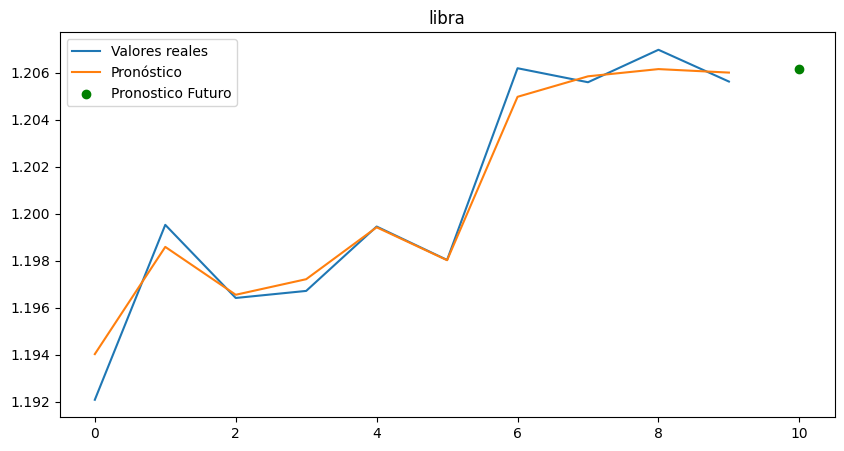

In [96]:
import xgboost as xgb
model = xgb.XGBRegressor(n_jobs=1, tree_method='hist', random_state=0, max_bin=500)
model.fit(x,y)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(y.values[-10:], label='Valores reales')
plt.plot(model.predict(x)[-10:], label='Pronóstico')
plt.scatter(x=10,
            y=model.predict(pd.concat([final_full.iloc[-1:,0:7], x.iloc[-1:,0:-7]], axis=1).values),
           color='green', label='Pronostico Futuro')
plt.title(str(y.name))
plt.legend()

In [97]:
print('------------------------------------------------------------------')
print('Forecast serie:', y.name)
print('------------------------------------------------------------------')

print('Actual data:', final_full.index[-1])

print(data_4h['libra'].iloc[-1])

#print('Past forecast:', model.predict(x.iloc[-1:,:]).item())

print('------------------------------------------------------------------')
print('Forecast data (4 hours ahead):', pd.Timestamp(data_4h.index[-1].asm8 + int(1.44e13)))

print('Predicted change(%):', str(np.round(((model.predict(pd.concat([final_full.iloc[-1:,0:7], x.iloc[-1:,0:-7]], axis=1).values) -
                               data_4h['libra'].iloc[-1])/data_4h['libra'].iloc[-1]).item()*100, 2))+'%')
print('------------------------------------------------------------------')

print('4 hours ahead forecast:')
print(model.predict(pd.concat([final_full.iloc[-1:,0:7], x.iloc[-1:,0:-7]], axis=1).values).item())

fc_libra = model.predict(pd.concat([final_full.iloc[-1:,0:7], x.iloc[-1:,0:-7]], axis=1).values).item()

------------------------------------------------------------------
Forecast serie: libra
------------------------------------------------------------------
Actual data: 2023-01-04 21:00:00
1.2056326866149902
------------------------------------------------------------------
Forecast data (4 hours ahead): 2023-01-05 01:00:00
Predicted change(%): 0.05%
------------------------------------------------------------------
4 hours ahead forecast:
1.2061842679977417


In [99]:
# Write with every run
print('Currently writing file:', str(int(data_4h.index[-1].asm8 + int(1.44e13))/int(1.44e13) - 116171.25))
pd.DataFrame([[fc_xrp, fc_libra]], columns=['fc_xrp', 'fc_libra'], index=[pd.Timestamp(data_4h.index[-1].asm8 + int(1.44e13))]).to_csv("fc_" + str(int(data_4h.index[-1].asm8 + int(1.44e13))/int(1.44e13) - 116171.25) + ".csv")

Currently writing file: 1.0
